In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import json

In [2]:
df = pd.read_csv(r"C:\Users\trilo\Downloads\End To End DATA DRITF Pipeline\data\processed\Preprocessed_Data.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [3]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = df.drop(columns=numeric_features + ['Churn']).columns.tolist()


In [4]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [7]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [16]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


 Model LogisticRegression trained successfully.

 Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.62      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

LogisticRegression — Accuracy: 0.789, ROC AUC: 0.832
Confusion Matrix:
[[916 117]
 [180 194]]


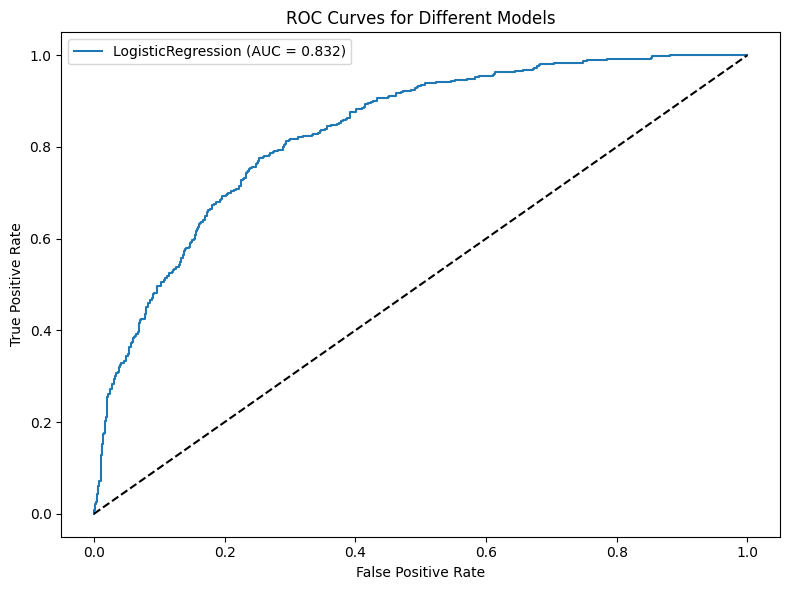

In [9]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
}

results = {}
metrics = {}

plt.figure(figsize=(8, 6))

for name, clf in models.items():
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    model.fit(X_train, y_train)
    print(f"\n Model {name} trained successfully.")

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n Classification Report for {name}:\n{classification_report(y_test, y_pred)}")
    acc = round(accuracy_score(y_test, y_pred), 3)
    auc = round(roc_auc_score(y_test, y_prob), 3)

    print(f"{name} — Accuracy: {acc}, ROC AUC: {auc}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc})")

    results[name] = {
        "pipeline": model,
        "auc": auc,
        "acc": acc
    }

    metrics[name] = {
        "accuracy": acc,
        "roc_auc": auc,
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
    }



plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.tight_layout()
plt.show()


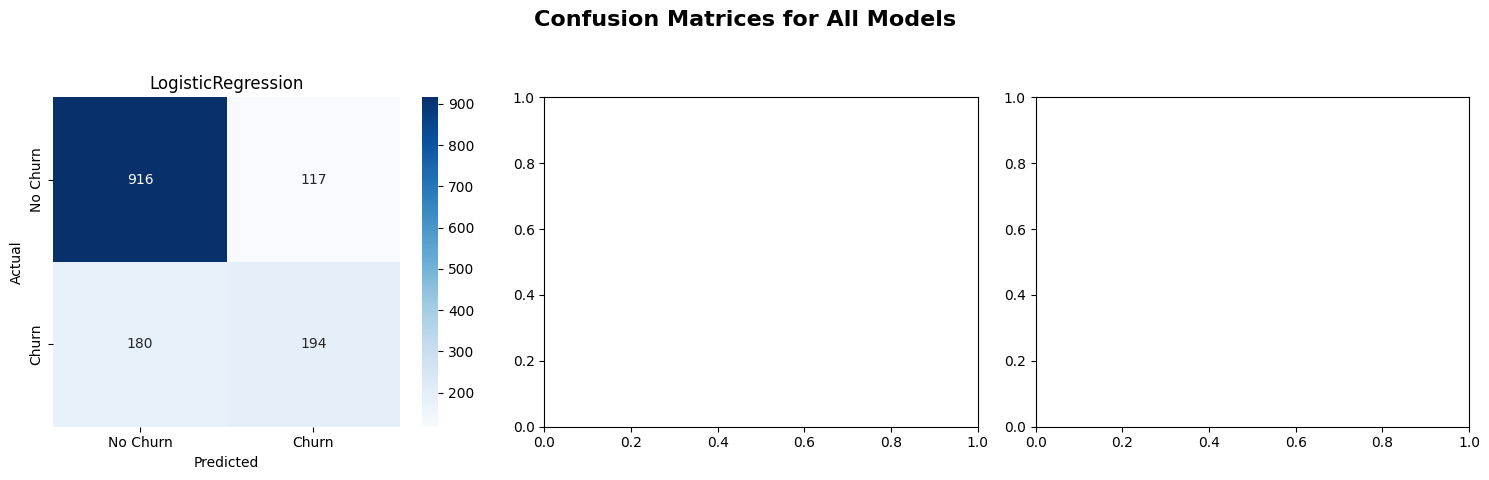

In [10]:
model_names = ["LogisticRegression"]
labels = ["No Churn", "Churn"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, name in enumerate(model_names):
    cm = np.array(metrics[name]["confusion_matrix"])
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(f"{name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.suptitle("Confusion Matrices for All Models", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [15]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test, y_prob)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_prob)
mae = mean_absolute_error(y_test, y_prob)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")

MSE: 0.1407
RMSE: 0.3750
R²: 0.2793
MAE: 0.2773
